# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей

Цель лабораторной работы: изучение способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

## Задание

1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
5. Произведите подбор гиперпараметра K с использованием GridSearchCV и RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Используйте не менее двух стратегий кросс-валидации.
Сравните метрики качества исходной и оптимальной моделей.

## Ход работы

### Выбор и загрузка датасета

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")
from sklearn.datasets import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold

def make_dataframe(ds_function):
    ds = ds_function()
    df = pd.DataFrame(data= np.c_[ds['data'], ds['target']],
                     columns= list(ds['feature_names']) + ['target'])
    return df

wine = load_wine()

df = make_dataframe(load_wine)

In [2]:
# Первые 5 строк датасета
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


In [3]:
# Проверим наличие пустых значений
# Цикл по колонкам датасета
for col in df.columns:
    # Количество пустых значений - все значения заполнены
    temp_null_count = df[df[col].isnull()].shape[0]
    print('{} - {}'.format(col, temp_null_count))

alcohol - 0
malic_acid - 0
ash - 0
alcalinity_of_ash - 0
magnesium - 0
total_phenols - 0
flavanoids - 0
nonflavanoid_phenols - 0
proanthocyanins - 0
color_intensity - 0
hue - 0
od280/od315_of_diluted_wines - 0
proline - 0
target - 0


In [4]:
# Масштабирование
scaler = MinMaxScaler()
df[['alcohol', 'hue']] = scaler.fit_transform(df[['alcohol', 'hue']])
data = df[['alcohol','hue','target']]
# data = pd.DataFrame(scaler.transform(df[['alcohol', 'hue']]), columns = ['alcohol', 'hue'])

In [5]:
data.head()

,alcohol,hue,target
0,0.842105,0.455285,0.0
1,0.571053,0.463415,0.0
2,0.560526,0.447154,0.0
3,0.878947,0.308943,0.0
4,0.581579,0.455285,0.0


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,0.518584,0.213639,0.0,0.350658,0.531579,0.696711,1.0
hue,178.0,0.388170,0.185831,0.0,0.245935,0.394309,0.520325,1.0
target,178.0,0.938202,0.775035,0.0,0.000000,1.000000,2.000000,2.0


<Axes: xlabel='alcohol', ylabel='hue'>

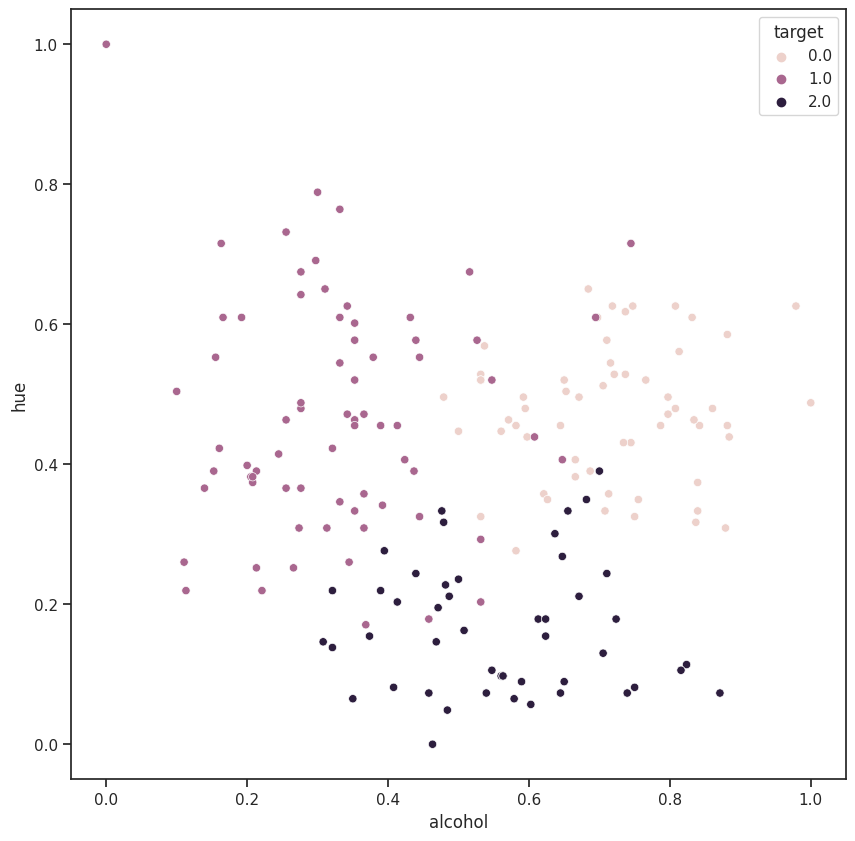

In [7]:
# Диаграмма рассеяния позволяет визуально обнаружить наличие зависимости
# Построим зависимость между крепкостью алкоголя и оттенком цвета
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(ax=ax, x='alcohol', y='hue', data=data, hue='target')

### Разделение на тестовую и обучающую

In [8]:
y = data['target']
x = data.drop('target', axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 20)

print(f"Обучающая выборка:\n{x_train, y_train}")
print(f"Тестовая выборка:\n{x_test, y_test}")

Обучающая выборка:
(      alcohol       hue
1    0.571053  0.463415
67   0.352632  0.520325
174  0.623684  0.178862
64   0.300000  0.788618
20   0.797368  0.495935
..        ...       ...
148  0.602632  0.056911
137  0.394737  0.276423
156  0.739474  0.073171
15   0.684211  0.650407
99   0.331579  0.764228

[142 rows x 2 columns], 1      0.0
67     1.0
174    2.0
64     1.0
20     0.0
      ... 
148    2.0
137    2.0
156    2.0
15     0.0
99     1.0
Name: target, Length: 142, dtype: float64)
Тестовая выборка:
(      alcohol       hue
111  0.392105  0.341463
177  0.815789  0.105691
46   0.881579  0.455285
112  0.192105  0.609756
91   0.255263  0.463415
72   0.647368  0.406504
140  0.500000  0.235772
107  0.444737  0.325203
125  0.273684  0.308943
169  0.623684  0.154472
47   0.755263  0.349593
165  0.710526  0.243902
120  0.110526  0.260163
62   0.694737  0.609756
13   0.978947  0.626016
92   0.436842  0.390244
87   0.163158  0.715447
28   0.747368  0.626016
51   0.736842  0.617886
155 

### Обучение и оценка качества модели для произвольного гиперпараметра K

In [9]:
cl1_5 = KNeighborsClassifier(n_neighbors=5).fit(x_train, y_train)

target1_5_train = cl1_5.predict(x_train)
target1_5_test = cl1_5.predict(x_test)

accuracy_score(y_train, target1_5_train), accuracy_score(y_test, target1_5_test)

(0.9436619718309859, 0.8333333333333334)

Чем выше значения - тем лучше

### Подбор гиперпараметров модели и кросс-валидация

#### Grid Search

In [10]:
n_range = np.array(range(5,31,1))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
         22, 23, 24, 25, 26, 27, 28, 29, 30])}]

In [11]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_gs.fit(x_train, y_train)

CPU times: user 716 ms, sys: 5.38 ms, total: 721 ms
Wall time: 731 ms


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30])}],
             scoring='accuracy')

In [12]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(n_neighbors=13)

In [13]:
# Лучшее значение метрики
clf_gs.best_score_

0.9150246305418719

In [14]:
# Лучшее значение параметров
clf_gs.best_params_

{'n_neighbors': 13}

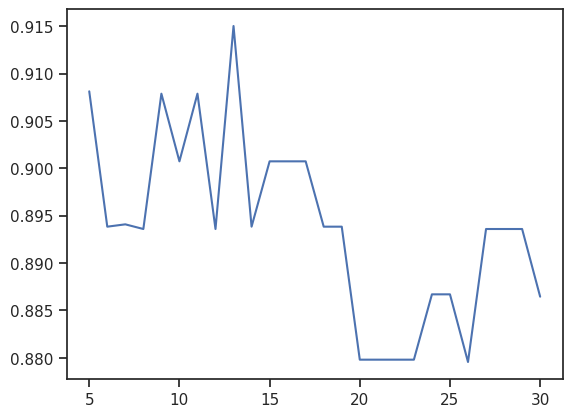

In [15]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

#### Randomized Search

In [16]:
%%time
clf_rs = RandomizedSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_rs.fit(x_train, y_train)

CPU times: user 370 ms, sys: 6.79 ms, total: 377 ms
Wall time: 394 ms


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions=[{'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30])}],
                   scoring='accuracy')

In [17]:
# В данном случае оба способа нашли одинаковое решение
clf_rs.best_score_, clf_rs.best_params_

(0.9081280788177342, {'n_neighbors': 5})

#### K-fold

In [18]:
X = data
kf = KFold(n_splits=10)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  

In [19]:
kf = KFold(n_splits=10)
scores = cross_val_score(KNeighborsClassifier(n_neighbors=13),
                         x, y, scoring='accuracy',
                         cv=kf)
scores

array([1.        , 0.94444444, 0.88888889, 0.77777778, 0.77777778,
       1.        , 0.88888889, 0.44444444, 1.        , 0.82352941])

In [20]:
kf = KFold(n_splits=10)
scores = cross_validate(KNeighborsClassifier(n_neighbors=13),
                        x, y, scoring='accuracy',
                        cv=kf, return_train_score=True)
scores

{'fit_time': array([0.0087955 , 0.00347543, 0.00305629, 0.00320578, 0.00406098,
        0.00320888, 0.00345302, 0.00322723, 0.00314999, 0.00322485]),
 'score_time': array([0.00715351, 0.00421238, 0.00407553, 0.00431013, 0.00415754,
        0.0040729 , 0.00857878, 0.00421596, 0.00407171, 0.00408387]),
 'test_score': array([1.        , 0.94444444, 0.88888889, 0.77777778, 0.77777778,
        1.        , 0.88888889, 0.44444444, 1.        , 0.82352941]),
 'train_score': array([0.88125   , 0.89375   , 0.90625   , 0.9125    , 0.90625   ,
        0.9       , 0.9125    , 0.925     , 0.8757764 , 0.88819876])}

#### ShuffleSplit

In [21]:
X = data
# Эквивалент KFold(n_splits=n)
kf = ShuffleSplit(n_splits=10, test_size=0.25)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[104  89 171 127 144 108 106 115  67 141  24 158 169  47  92 176  79 113
  59  63 139  28   0  15  72 149  20 122 143 170 135  96 116  38  68 146
   2  78 159  39 172 110  99 174 112  98  57 126 107  16  36  82  61   1
 129 138  31 173  65 145 125 133  22 161  18  23  94 142 140 102  50  62
 132  53 105  27  74  73 118  80 128   8  91 114  69  83  13   5 136   7
  11 137 120 103  49  41  30  77   9 153 156  81 177  95 101   6 134  34
 119 175  33  86 157 167  12  56  48  29   3  71  45 100  84  52  14  54
 162 151  87 150  60 124 131] [155 148  43 123  85  19  25  40  37  75  64  46 147  51  55  21 160 168
 109 121 163 166  88  44  42  26  97  66 164 152  93  90  10   4 117 165
 154  70  58  35 111 130  76  32  17]
[144 107 166  77 168 157 131  85 150  31  68  84 151 124  28  14  91 125
 164  62 146   3  19  76  66 135  16 162  55  99  22  70  38 119  93  44
  88  96  87  54  95  45  79 153 132 110  36 117  43 108   7  73  35 156
   4 109 142 115  67  37 160  11 176 104  71 171 129  74

In [22]:
kf = ShuffleSplit(n_splits=10, test_size=0.25)
scores = cross_val_score(KNeighborsClassifier(n_neighbors=13),
                         x, y, scoring='accuracy',
                         cv=kf)
scores

array([0.86666667, 0.93333333, 0.84444444, 0.82222222, 0.91111111,
       0.93333333, 0.84444444, 0.91111111, 0.82222222, 0.95555556])

In [23]:
kf = ShuffleSplit(n_splits=10, test_size=0.25)
scores = cross_validate(KNeighborsClassifier(n_neighbors=13),
                        x, y, scoring='accuracy',
                        cv=kf, return_train_score=True)
scores

{'fit_time': array([0.00341344, 0.00318074, 0.00349307, 0.00326228, 0.00314689,
        0.00294709, 0.00316525, 0.00310755, 0.00315619, 0.00332642]),
 'score_time': array([0.00558805, 0.00518012, 0.00516868, 0.00531459, 0.0069952 ,
        0.00501132, 0.00560713, 0.00512195, 0.005404  , 0.00509   ]),
 'test_score': array([0.77777778, 0.93333333, 0.91111111, 0.95555556, 0.93333333,
        0.77777778, 0.86666667, 0.84444444, 0.88888889, 0.82222222]),
 'train_score': array([0.93233083, 0.90225564, 0.88721805, 0.88721805, 0.87969925,
        0.93984962, 0.88721805, 0.91729323, 0.90977444, 0.93233083])}